# O quão bom é Max Verstappen? Uma análise de dados

Neste notebook, apresento uma análise de dados construída a partir de um dataset do Kaggle, previamente extraído e refinado dentro da própria codebase em que este notebook está hospedado.

O objetivo é responder, de forma analítica, à pergunta: **“O quão bom é Max Verstappen?”**
Para isso, sigo uma narrativa dedutiva, partindo de indicadores mais gerais — como número de vitórias, pódios e títulos — a fim de estabelecer um panorama inicial e nivelar o contexto para qualquer leitor: estamos, sem dúvida, diante de um dos maiores pilotos da Fórmula 1 moderna.

Em seguida, à medida que a análise se aprofunda, passo a examinar métricas mais específicas e comparativas — como consistência de desempenho, diferença em relação aos companheiros de equipe e outros fatores que ajudam a isolar variáveis externas, como o desempenho do carro ou da equipe.
O objetivo é ir além da “obviedade” dos números brutos, buscando entender até que ponto o domínio de Verstappen é reflexo do carro ou resultado do próprio piloto.

#### Avisos gerais em relação a análise:

- Os dados utilizados foram extraídos do dataset Kaggle: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020
    - Ver notebook: `explore_data.ipynb` para ter acesso ao "check de sanidade" que fiz do dataset e entender um pouco de suas limitações.
- No momento da análise, o campeonado de 2025 segue em andamento e dados referentes ao mesmo não estarão presentes na análise.

## Setup da análise:

Imports, configs etc...

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import utils as fxns
import os
from pathlib import Path
import utils as fxns
from dateutil.relativedelta import relativedelta

# Caminho absoluto da raiz do projeto
project_root = Path.cwd().parent  # se o notebook está em /notebooks
os.chdir(project_root)

print("Diretório atual:", Path.cwd())

Diretório atual: b:\projetos\f1_analytics


In [3]:
from src.modules.db_reader import DbReader
from src.data_viz.plotter import Plotter
f1_db = DbReader()
plotter = Plotter()

### Importando os datasets:

In [4]:
# Corridas:

df_races = f1_db.run_query_file("data/db_queries/race_results_report.sql").drop_duplicates()
df_races['race_date'] = pd.to_datetime(df_races['race_date'])

df_races

,race_name,year,race_date,circuit_name,circuit_country,driver_id,driver_code,driver_forename,driver_surname,driver_full_name,...,finishing_position,points_scored,laps_completed,time_in_race,time_in_race_ms,fastest_lap_number,fastest_lap_rank,fastest_lap_time,fastest_lap_speed,race_status
0,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,1,HAM,Lewis,Hamilton,Lewis Hamilton,...,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,Finished
1,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,2,HEI,Nick,Heidfeld,Nick Heidfeld,...,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,Finished
2,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,3,ROS,Nico,Rosberg,Nico Rosberg,...,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,Finished
3,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,4,ALO,Fernando,Alonso,Fernando Alonso,...,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,Finished
4,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,5,KOV,Heikki,Kovalainen,Heikki Kovalainen,...,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,Finished
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26754,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,825,MAG,Kevin,Magnussen,Kevin Magnussen,...,16,0.0,57,\N,\N,57,1,1:25.637,222.002,+1 Lap
26755,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,859,LAW,Liam,Lawson,Liam Lawson,...,17,0.0,55,\N,\N,52,12,1:28.751,214.212,Engine
26756,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,822,BOT,Valtteri,Bottas,Valtteri Bottas,...,18,0.0,30,\N,\N,14,19,1:29.482,212.462,Collision damage
26757,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,861,COL,Franco,Colapinto,Franco Colapinto,...,19,0.0,26,\N,\N,5,17,1:29.411,212.631,Engine


In [5]:
# Infos sobre pilotos:

df_drivers = f1_db.run_query_file("data/db_queries/drivers.sql").drop_duplicates()
df_drivers['dob'] = pd.to_datetime(df_drivers['dob'])
df_drivers


,driver_id,driver_code,driver_forename,driver_surname,driver_full_name,dob
0,1,HAM,Lewis,Hamilton,Lewis Hamilton,1985-01-07
1,2,HEI,Nick,Heidfeld,Nick Heidfeld,1977-05-10
2,3,ROS,Nico,Rosberg,Nico Rosberg,1985-06-27
3,4,ALO,Fernando,Alonso,Fernando Alonso,1981-07-29
4,5,KOV,Heikki,Kovalainen,Heikki Kovalainen,1981-10-19
...,...,...,...,...,...,...
856,858,SAR,Logan,Sargeant,Logan Sargeant,2000-12-31
857,859,LAW,Liam,Lawson,Liam Lawson,2002-02-11
858,860,BEA,Oliver,Bearman,Oliver Bearman,2005-05-08
859,861,COL,Franco,Colapinto,Franco Colapinto,2003-05-27


In [6]:
df_lap_times = f1_db.run_query_file("data/db_queries/lap_times_report.sql").drop_duplicates()
df_lap_times['race_date'] = pd.to_datetime(df_lap_times['race_date'])
df_lap_times

,race_name,year,race_date,circuit_name,circuit_country,driver_code,driver_forename,driver_surname,driver_full_name,driver_nationality,lap_number,position_on_lap,lap_time,lap_time_ms
0,Australian Grand Prix,1996,1996-03-10,Albert Park Grand Prix Circuit,Australia,VIL,Jacques,Villeneuve,Jacques Villeneuve,Canadian,1,1,1:43.702,103702
1,Australian Grand Prix,1996,1996-03-10,Albert Park Grand Prix Circuit,Australia,\N,Damon,Hill,Damon Hill,British,1,2,1:44.243,104243
2,Australian Grand Prix,1996,1996-03-10,Albert Park Grand Prix Circuit,Australia,\N,Eddie,Irvine,Eddie Irvine,British,1,3,1:44.981,104981
3,Australian Grand Prix,1996,1996-03-10,Albert Park Grand Prix Circuit,Australia,MSC,Michael,Schumacher,Michael Schumacher,German,1,4,1:45.188,105188
4,Australian Grand Prix,1996,1996-03-10,Albert Park Grand Prix Circuit,Australia,\N,Jean,Alesi,Jean Alesi,French,1,5,1:46.506,106506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589076,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,VER,Max,Verstappen,Max Verstappen,Dutch,58,6,1:28.780,88780
589077,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,GAS,Pierre,Gasly,Pierre Gasly,French,58,7,1:30.865,90865
589078,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,HUL,Nico,Hülkenberg,Nico Hülkenberg,German,58,8,1:30.040,90040
589079,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,ALO,Fernando,Alonso,Fernando Alonso,Spanish,58,9,1:28.621,88621


In [7]:
# Vou adicionar a idade no dataset de corridas, já que vou acabar usando isso agora e em outros momentos:

df_races = pd.merge(
    df_races,
    df_drivers[['driver_id', 'dob']],
    on='driver_id',
    how='left'
)

df_races['driver_age_at_race'] = df_races.apply(lambda row: fxns.calcula_idade(row['dob'], row['race_date']), axis=1)
df_races

,race_name,year,race_date,circuit_name,circuit_country,driver_id,driver_code,driver_forename,driver_surname,driver_full_name,...,laps_completed,time_in_race,time_in_race_ms,fastest_lap_number,fastest_lap_rank,fastest_lap_time,fastest_lap_speed,race_status,dob,driver_age_at_race
0,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,1,HAM,Lewis,Hamilton,Lewis Hamilton,...,58,1:34:50.616,5690616,39,2,1:27.452,218.300,Finished,1985-01-07,23.186858
1,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,2,HEI,Nick,Heidfeld,Nick Heidfeld,...,58,+5.478,5696094,41,3,1:27.739,217.586,Finished,1977-05-10,30.850103
2,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,3,ROS,Nico,Rosberg,Nico Rosberg,...,58,+8.163,5698779,41,5,1:28.090,216.719,Finished,1985-06-27,22.718686
3,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,4,ALO,Fernando,Alonso,Fernando Alonso,...,58,+17.181,5707797,58,7,1:28.603,215.464,Finished,1981-07-29,26.631075
4,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,5,KOV,Heikki,Kovalainen,Heikki Kovalainen,...,58,+18.014,5708630,43,1,1:27.418,218.385,Finished,1981-10-19,26.406571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26754,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,825,MAG,Kevin,Magnussen,Kevin Magnussen,...,57,\N,\N,57,1,1:25.637,222.002,+1 Lap,1992-10-05,32.175222
26755,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,859,LAW,Liam,Lawson,Liam Lawson,...,55,\N,\N,52,12,1:28.751,214.212,Engine,2002-02-11,22.822724
26756,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,822,BOT,Valtteri,Bottas,Valtteri Bottas,...,30,\N,\N,14,19,1:29.482,212.462,Collision damage,1989-08-28,35.279945
26757,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,861,COL,Franco,Colapinto,Franco Colapinto,...,26,\N,\N,5,17,1:29.411,212.631,Engine,2003-05-27,21.535934


## Começando do começo...

Max Verstappen chegou fazendo barulho na F1, sendo o piloto mais jovem da história da F1 ao largar em uma corrida:

In [8]:
df_first_race = fxns.gerar_dataset_primeiro_evento(df_races, df_drivers)


In [9]:
df_top_10_jovens_largada = df_first_race.sort_values("idade_primeiro_evento").head(10)
df_top_10_jovens_largada

,driver_id,driver_full_name,race_name,race_date,year,circuit_name,circuit_country,race_status,finishing_position,starting_position,dob,idade_primeiro_evento
571,830,Max Verstappen,Australian Grand Prix,2015-03-15,2015,Albert Park Grand Prix Circuit,Australia,Engine,13,11,1997-09-30,17.453799
510,840,Lance Stroll,Australian Grand Prix,2017-03-26,2017,Albert Park Grand Prix Circuit,Australia,Brakes,16,20,1998-10-29,18.406571
625,860,Oliver Bearman,Saudi Arabian Grand Prix,2024-03-09,2024,Jeddah Corniche Circuit,Saudi Arabia,Finished,7,11,2005-05-08,18.836413
511,846,Lando Norris,Australian Grand Prix,2019-03-17,2019,Albert Park Grand Prix Circuit,Australia,+1 Lap,12,8,1999-11-13,19.340178
392,153,Jaime Alguersuari,Hungarian Grand Prix,2009-07-26,2009,Hungaroring,Hungary,+1 Lap,15,19,1990-03-23,19.342916
597,191,Mike Thackwell,Dutch Grand Prix,1980-08-31,1980,Circuit Park Zandvoort,Netherlands,Did not qualify,27,0,1961-03-30,19.422313
713,454,Ricardo Rodríguez,Italian Grand Prix,1961-09-10,1961,Autodromo Nazionale di Monza,Italy,Fuel system,17,2,1942-02-14,19.570157
256,4,Fernando Alonso,Australian Grand Prix,2001-03-04,2001,Albert Park Grand Prix Circuit,Australia,+2 Laps,12,19,1981-07-29,19.597536
247,74,Esteban Tuero,Australian Grand Prix,1998-03-08,1998,Albert Park Grand Prix Circuit,Australia,Engine,15,17,1978-04-22,19.876797
171,826,Daniil Kvyat,Australian Grand Prix,2014-03-16,2014,Albert Park Grand Prix Circuit,Australia,Finished,9,8,1994-04-26,19.887748


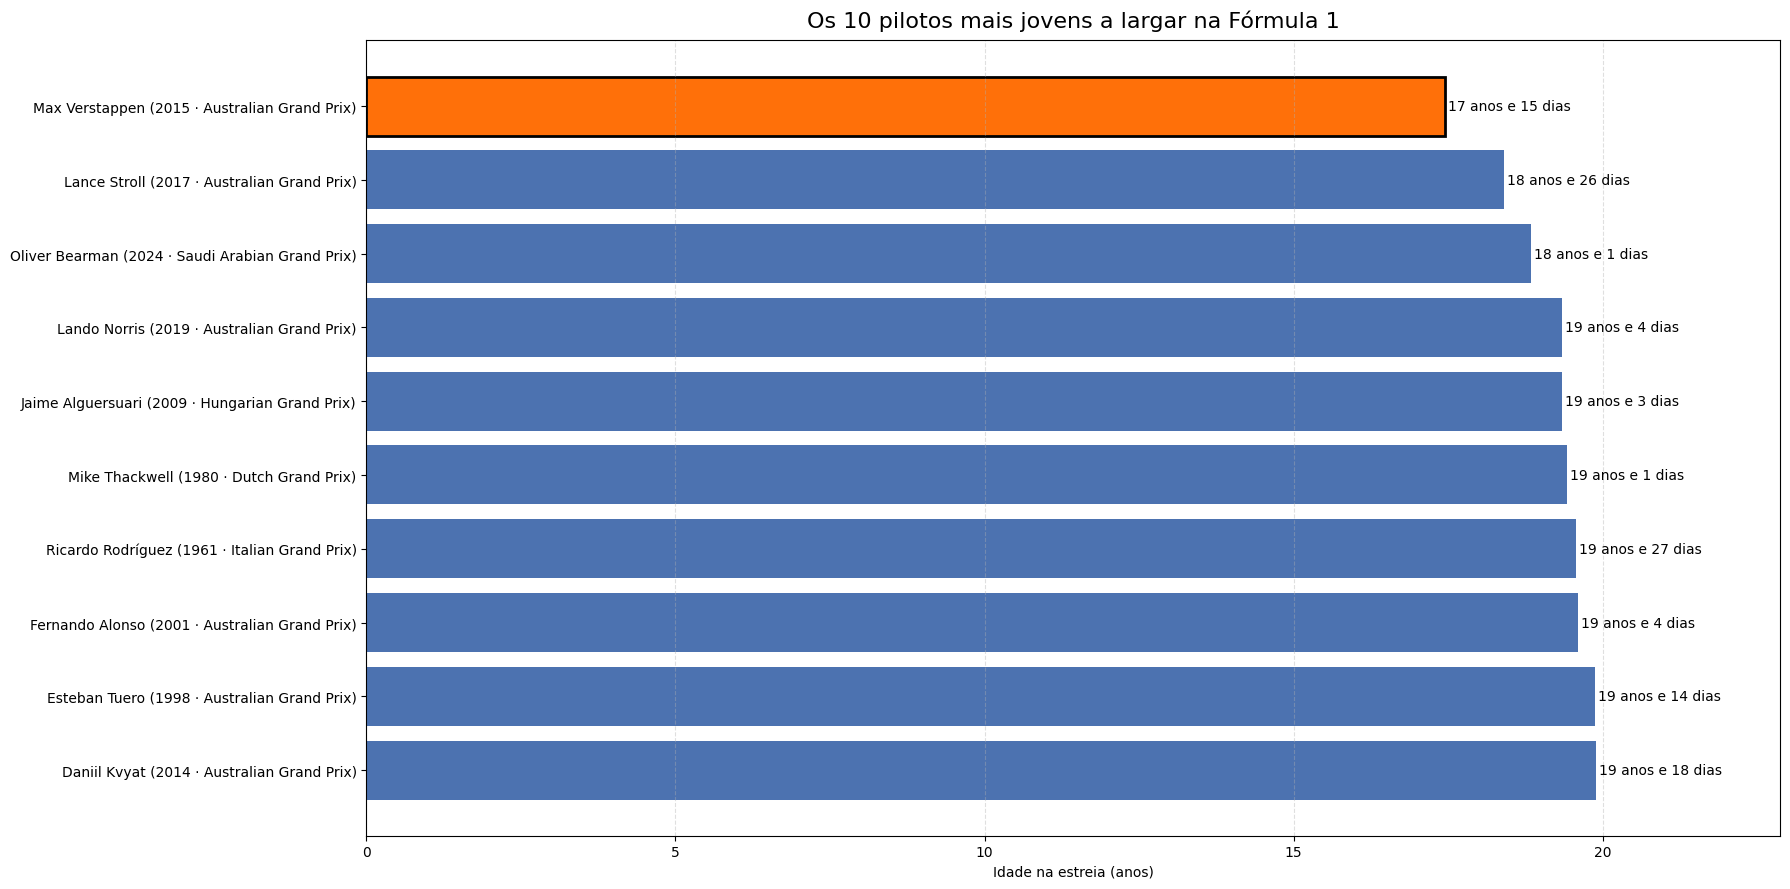

In [10]:
fxns.gera_graf_top_10_mais_jovens(df_top_10_jovens_largada, "Os 10 pilotos mais jovens a largar na Fórmula 1", "Idade na estreia (anos)", "Verstappen")

E vai além, ele não apenas possui essa marca considerando estréia, mas pra vitória na F1 também.

In [11]:
# Vamos gerar um dataset com a primeira vitória de cada piloto por idade no momento em que conquistou a sua vitória:

df_race_wins = df_races[df_races['finishing_position'] == 1].copy()

df_first_win = fxns.gerar_dataset_primeiro_evento(df_race_wins, df_drivers)

In [12]:
# Agora pego os 10 mais jovens:

df_top_10_jovens_vencedores = df_first_win.sort_values("idade_primeiro_evento").head(10)
df_top_10_jovens_vencedores

,driver_id,driver_full_name,race_name,race_date,year,circuit_name,circuit_country,race_status,finishing_position,starting_position,dob,idade_primeiro_evento
74,830,Max Verstappen,Spanish Grand Prix,2016-05-15,2016,Circuit de Barcelona-Catalunya,Spain,Finished,1,4,1997-09-30,18.622861
106,20,Sebastian Vettel,Italian Grand Prix,2008-09-14,2008,Autodromo Nazionale di Monza,Italy,Finished,1,1,1987-07-03,21.201916
11,844,Charles Leclerc,Belgian Grand Prix,2019-09-01,2019,Circuit de Spa-Francorchamps,Belgium,Finished,1,1,1997-10-16,21.875428
24,4,Fernando Alonso,Hungarian Grand Prix,2003-08-24,2003,Hungaroring,Hungary,Finished,1,1,1981-07-29,22.069815
111,526,Troy Ruttman,Indianapolis 500,1952-05-30,1952,Indianapolis Motor Speedway,USA,Finished,1,7,1930-03-11,22.220397
7,360,Bruce McLaren,United States Grand Prix,1959-12-12,1959,Sebring International Raceway,USA,Finished,1,10,1937-08-30,22.283368
66,1,Lewis Hamilton,Canadian Grand Prix,2007-06-10,2007,Circuit Gilles Villeneuve,Canada,Finished,1,1,1985-01-07,22.420260
85,857,Oscar Piastri,Hungarian Grand Prix,2024-07-21,2024,Hungaroring,Hungary,Finished,1,2,2001-04-06,23.290897
63,8,Kimi Räikkönen,Malaysian Grand Prix,2003-03-23,2003,Sepang International Circuit,Malaysia,Finished,1,7,1979-10-17,23.430527
101,9,Robert Kubica,Canadian Grand Prix,2008-06-08,2008,Circuit Gilles Villeneuve,Canada,Finished,1,2,1984-12-07,23.501711


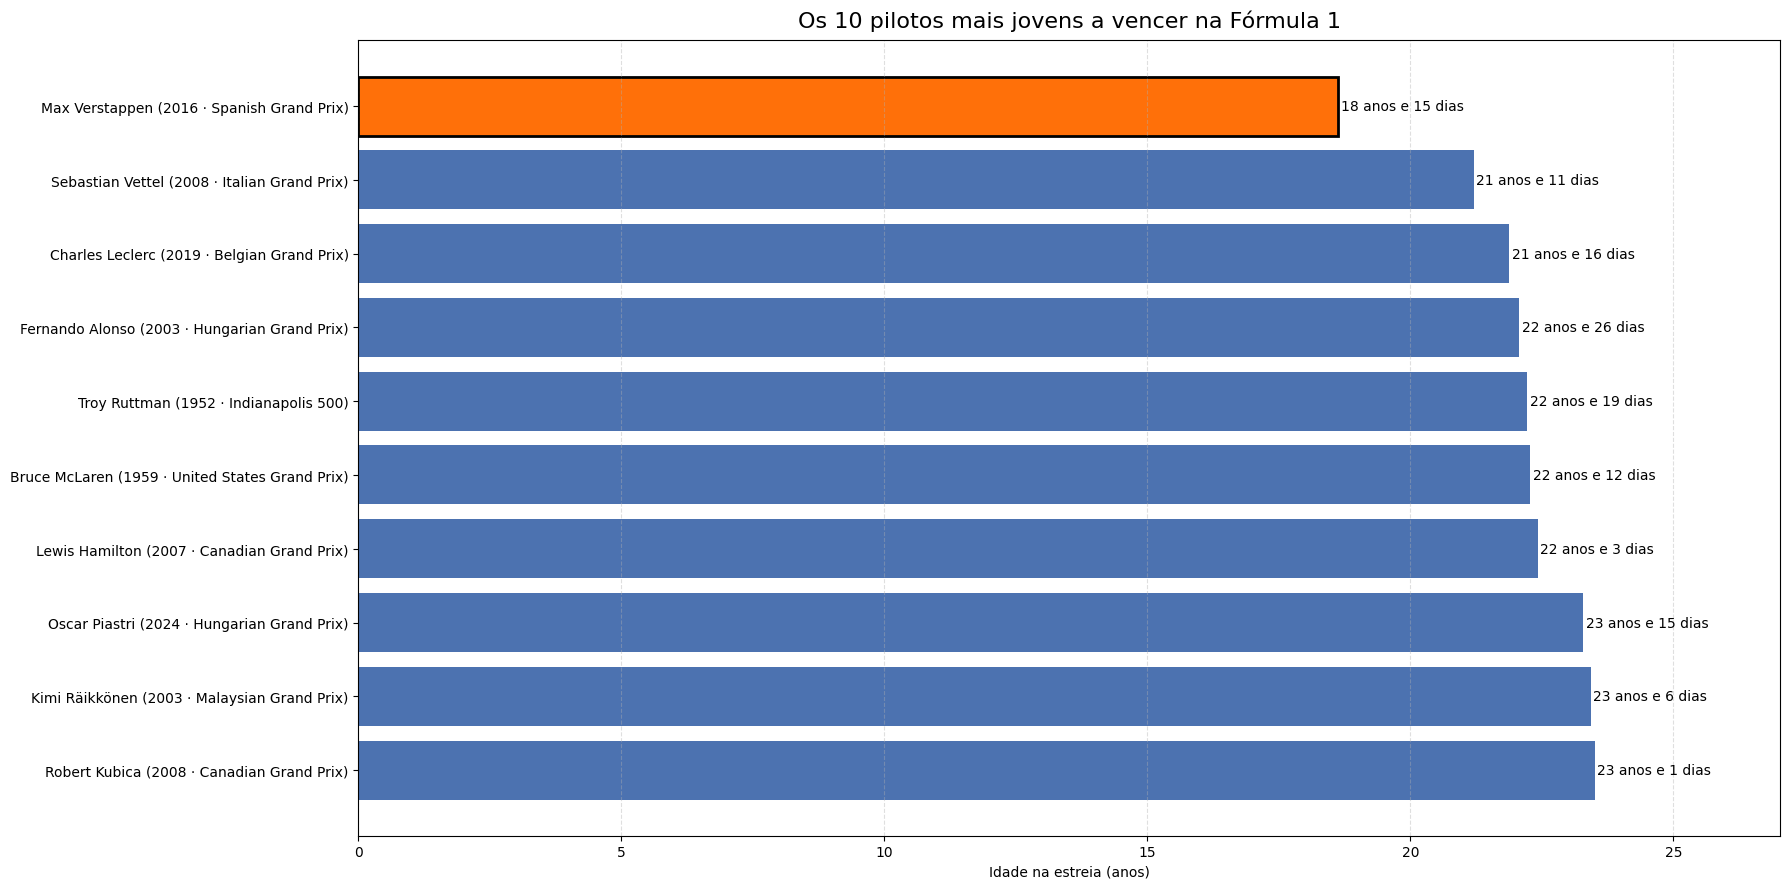

In [13]:
fxns.gera_graf_top_10_mais_jovens(df_top_10_jovens_vencedores, "Os 10 pilotos mais jovens a vencer na Fórmula 1", "Idade na estreia (anos)", "Verstappen")

## Mas... e desde então?

Beleza, acima conseguimos ver que o Verstappen não só foi o mais jovem estreante da F1 mas também foi o mais jovem a ganhar uma corrida, um ano após a sua estreia.

Mas, desde então, se fizermos uma visão geral dos números de vitórias, poles etc, Verstappen continua tendo marcas interessantes? Vamos dar uma olhada em alguns números gerais e a partir disso podemos ir aprofundando as nossas análises.

### Pole Positions:

In [14]:
df_races

,race_name,year,race_date,circuit_name,circuit_country,driver_id,driver_code,driver_forename,driver_surname,driver_full_name,...,laps_completed,time_in_race,time_in_race_ms,fastest_lap_number,fastest_lap_rank,fastest_lap_time,fastest_lap_speed,race_status,dob,driver_age_at_race
0,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,1,HAM,Lewis,Hamilton,Lewis Hamilton,...,58,1:34:50.616,5690616,39,2,1:27.452,218.300,Finished,1985-01-07,23.186858
1,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,2,HEI,Nick,Heidfeld,Nick Heidfeld,...,58,+5.478,5696094,41,3,1:27.739,217.586,Finished,1977-05-10,30.850103
2,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,3,ROS,Nico,Rosberg,Nico Rosberg,...,58,+8.163,5698779,41,5,1:28.090,216.719,Finished,1985-06-27,22.718686
3,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,4,ALO,Fernando,Alonso,Fernando Alonso,...,58,+17.181,5707797,58,7,1:28.603,215.464,Finished,1981-07-29,26.631075
4,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,5,KOV,Heikki,Kovalainen,Heikki Kovalainen,...,58,+18.014,5708630,43,1,1:27.418,218.385,Finished,1981-10-19,26.406571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26754,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,825,MAG,Kevin,Magnussen,Kevin Magnussen,...,57,\N,\N,57,1,1:25.637,222.002,+1 Lap,1992-10-05,32.175222
26755,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,859,LAW,Liam,Lawson,Liam Lawson,...,55,\N,\N,52,12,1:28.751,214.212,Engine,2002-02-11,22.822724
26756,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,822,BOT,Valtteri,Bottas,Valtteri Bottas,...,30,\N,\N,14,19,1:29.482,212.462,Collision damage,1989-08-28,35.279945
26757,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,861,COL,Franco,Colapinto,Franco Colapinto,...,26,\N,\N,5,17,1:29.411,212.631,Engine,2003-05-27,21.535934


In [15]:
df_pole_positions = df_races[df_races['starting_position'] == 1].copy()

df_pole_positions_agrup = df_pole_positions.groupby('driver_full_name').agg(
    {
        'race_name': 'count',
        'driver_age_at_race': 'max'
    }
).rename(columns={'race_name': 'pole_positions', 'driver_age_at_race': 'oldest_pole_position_age'}).reset_index().sort_values(by='pole_positions', ascending=False)

df_pole_positions_agrup

,driver_full_name,pole_positions,oldest_pole_position_age
64,Lewis Hamilton,104,38.537988
72,Michael Schumacher,68,37.530459
4,Ayrton Senna,65,34.110883
98,Sebastian Vettel,57,32.279261
71,Max Verstappen,40,26.748802
...,...,...,...
103,Thierry Boutsen,1,33.081451
104,Tom Pryce,1,26.102669
107,Vittorio Brambilla,1,37.571526
108,Walt Faulkner,1,30.283368


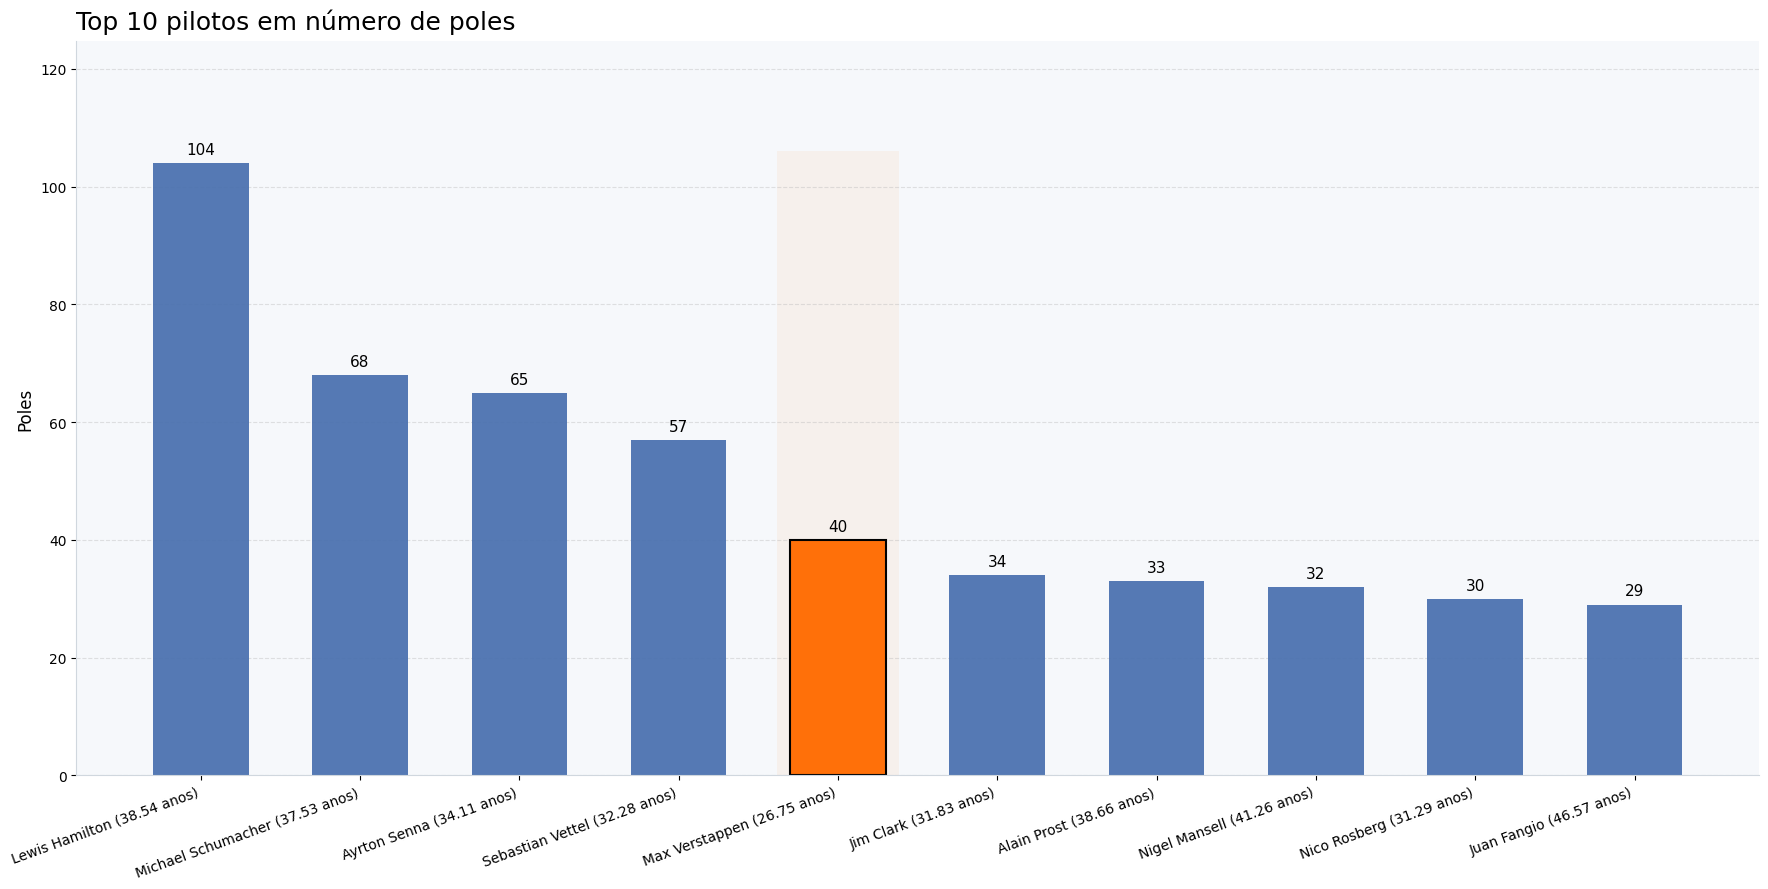

In [16]:
# Vamos tornar isso visual pra ficar mais fácil de expor a informação:

df_poles_top10 = df_pole_positions_agrup.head(10).copy()

df_poles_top10['nome_e_idade'] = df_poles_top10.apply(lambda row: f"{row['driver_full_name']} ({round(row['oldest_pole_position_age'], 2)} anos)", axis=1)

fxns.graf_top10_pilotos(
    df_poles_top10,
    col_nome="nome_e_idade",
    col_valor="pole_positions",
    titulo="Top 10 pilotos em número de poles",
    xlabel="Poles",
    nome_a_destacar="Verstappen",
    orientation='vertical',
    mostrar_chips=False
)


Acima não só podemos ver que o Verstappen é o número 5 em maior quantidade de pole positions na história da F1, como também ele é o mais jovem entre todos os pilotos que estão presentes na lista dos Top 10, sendo aproximadamente 5 anos mais jovem do que o 2o piloto mais jovem que seria o Nico Rosberg.

**Obs**.: a idade apresentada é a idade do piloto ao conseguir sua última pole presente na base de dados, faço assim pra tentar nivelar a comparação, ou seja, considero apenas a idade do piloto enquanto ele estava aumentando sua estatística de pole position.

O piloto que chega mais perto de Verstappen em termos de idade e que possui um volume bem considerável de pole positions seria o Leclerc, que cairia bem no Top 11. Porém, possui 26 pole positions, que equivale a 65% da quantidade de pole positions de Max Verstappen:

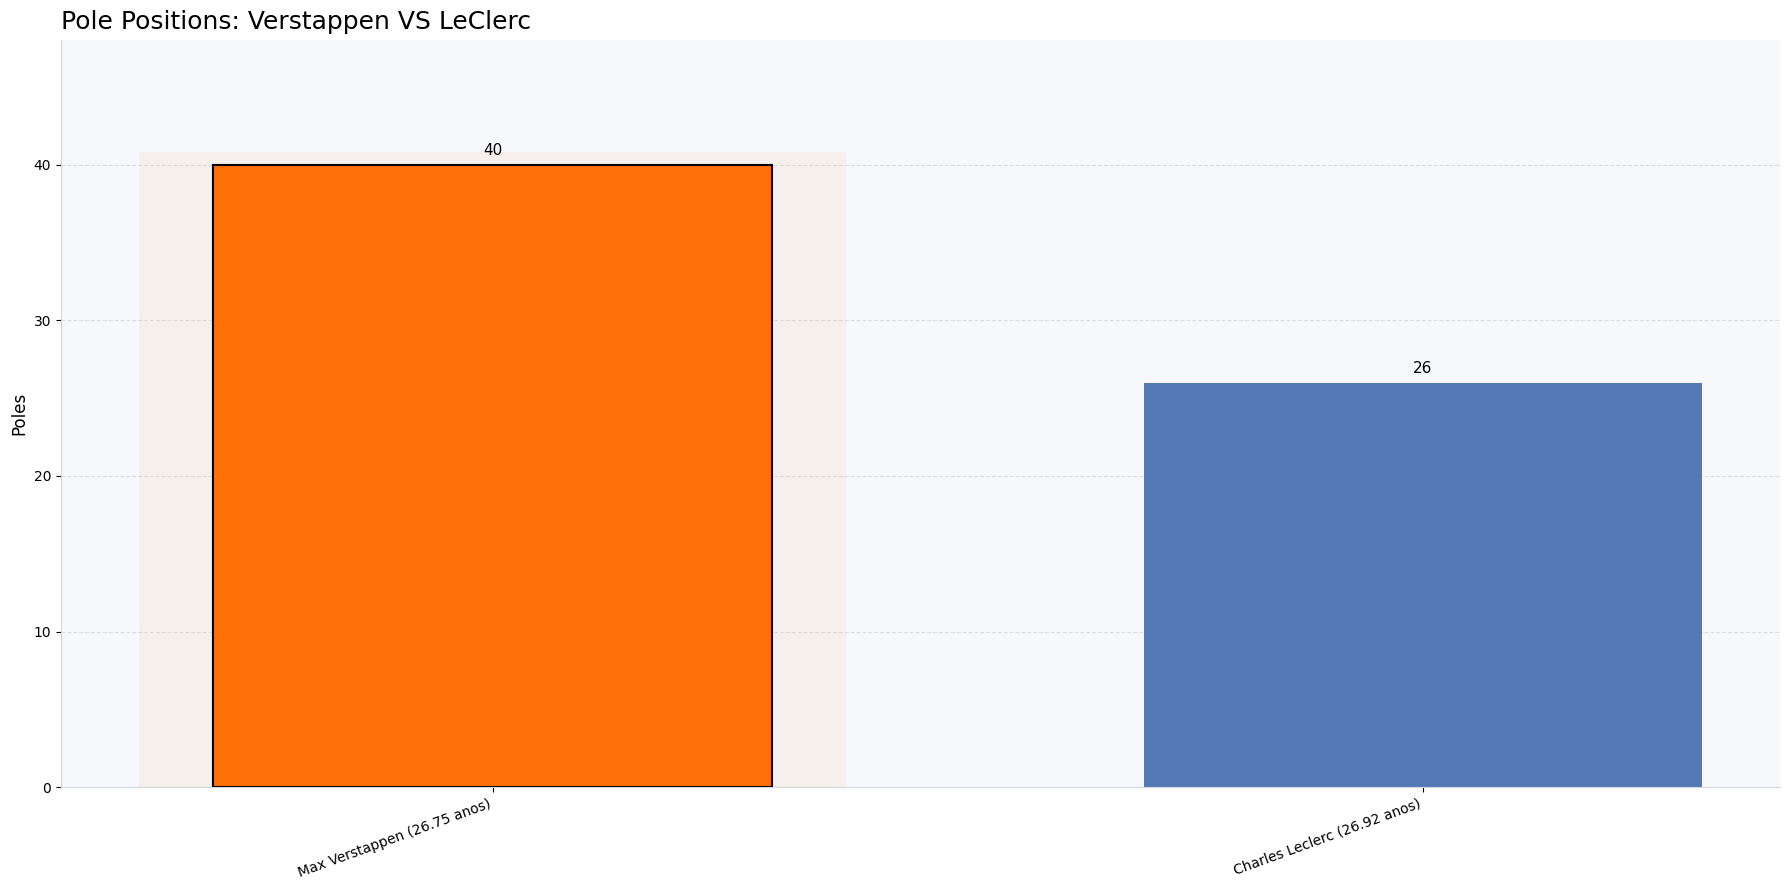

In [17]:
df_poles_ver_lec = df_pole_positions_agrup[df_pole_positions_agrup['driver_full_name'].str.contains('Verstappen|Leclerc', case=False, na=False)].copy()

df_poles_ver_lec['nome_e_idade'] = df_poles_ver_lec.apply(lambda row: f"{row['driver_full_name']} ({round(row['oldest_pole_position_age'], 2)} anos)", axis=1)

fxns.graf_top10_pilotos(
    df_poles_ver_lec,
    col_nome="nome_e_idade",
    col_valor="pole_positions",
    titulo="Pole Positions: Verstappen VS LeClerc",
    xlabel="Poles",
    nome_a_destacar="Verstappen",
    orientation='vertical',
    mostrar_chips=False
)


### Vitórias:

In [18]:
df_race_wins = df_races[df_races['finishing_position'] == 1].copy()

df_race_wins_agrup = df_race_wins.groupby('driver_full_name').agg(
    {
        'race_name': 'count',
        'driver_age_at_race': 'max'
    }
).rename(columns={'race_name': 'race_wins', 'driver_age_at_race': 'oldest_race_win_age'}).reset_index().sort_values(by='race_wins', ascending=False)

df_race_wins_agrup

,driver_full_name,race_wins,oldest_race_win_age
66,Lewis Hamilton,105,39.553730
75,Michael Schumacher,91,37.741273
74,Max Verstappen,63,27.170431
106,Sebastian Vettel,53,32.221766
0,Alain Prost,51,38.414784
...,...,...,...
102,Rodger Ward,1,38.381930
105,Sam Hanks,1,42.880219
100,Richie Ginther,1,35.219713
111,Troy Ruttman,1,22.220397


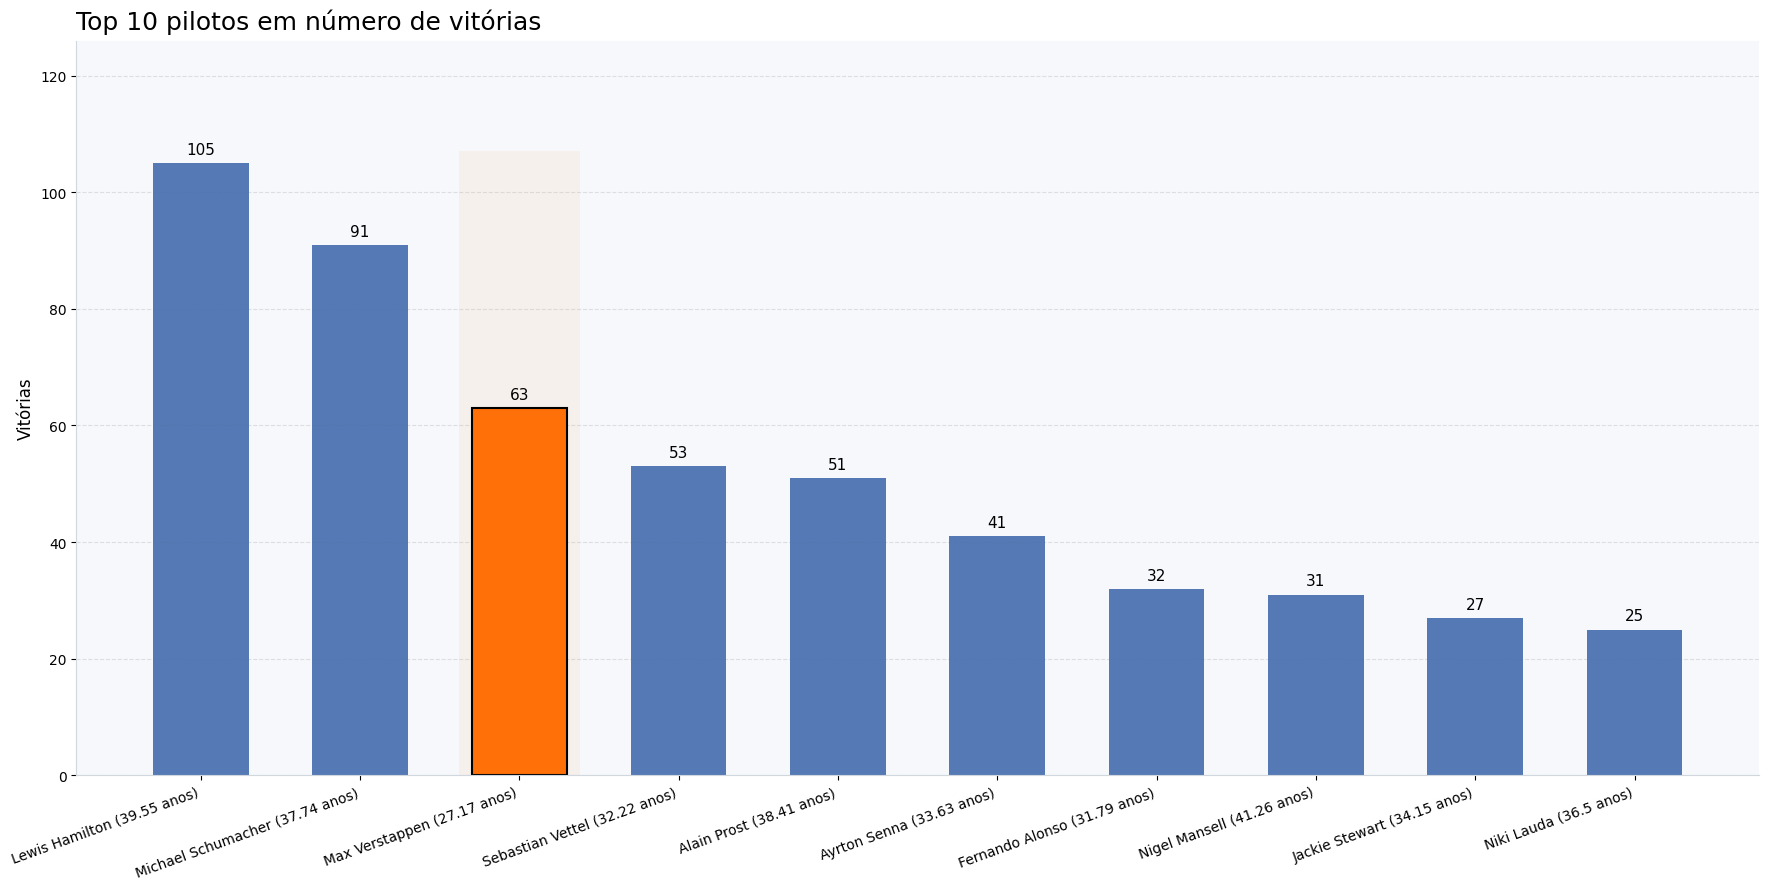

In [19]:
# Vamos tornar isso visual pra ficar mais fácil de expor a informação:

df_race_wins_top_10 = df_race_wins_agrup.head(10).copy()

df_race_wins_top_10['nome_e_idade'] = df_race_wins_top_10.apply(lambda row: f"{row['driver_full_name']} ({round(row['oldest_race_win_age'], 2)} anos)", axis=1)

fxns.graf_top10_pilotos(
    df_race_wins_top_10,
    col_nome="nome_e_idade",
    col_valor="race_wins",
    titulo="Top 10 pilotos em número de vitórias",
    xlabel="Vitórias",
    nome_a_destacar="Verstappen",
    orientation='vertical',
    mostrar_chips=False
)


Bom, eu acho que o gráfico acima nem precisa de muita explicação. Podemos ver que o Verstappen é o 3o piloto com maior número de vitórias da história e é o mais jovem por uma margem de 5 anos na lista, sendo que Vettel é o segundo mais jovem na lista de top 10, com 10 vitórias a menos ao final de 2024, ano no qual Vettel está aposentado e Verstappen continua correndo em 2025.

### E se olharmos em termos percentuais?

In [20]:
# Posso trazer a quantidade total de corridas de cada piloto pro dataset que usei pra ver as vitórias e calcular um percentual

df_driver_total_races = df_races.groupby('driver_full_name').agg({'race_name':'count'}).rename(columns={'race_name':'total_races'})


df_race_wins_agrup = pd.merge(
    left=df_race_wins_agrup,
    right=df_driver_total_races,
    on='driver_full_name',
    how='left'
)

df_race_wins_agrup['win_percentage'] = df_race_wins_agrup['race_wins'] / df_race_wins_agrup['total_races']

In [21]:
df_race_wins_agrup

,driver_full_name,race_wins,oldest_race_win_age,total_races,win_percentage
0,Lewis Hamilton,105,39.553730,356,0.294944
1,Michael Schumacher,91,37.741273,308,0.295455
2,Max Verstappen,63,27.170431,209,0.301435
3,Sebastian Vettel,53,32.221766,300,0.176667
4,Alain Prost,51,38.414784,202,0.252475
...,...,...,...,...,...
110,Rodger Ward,1,38.381930,12,0.083333
111,Sam Hanks,1,42.880219,9,0.111111
112,Richie Ginther,1,35.219713,54,0.018519
113,Troy Ruttman,1,22.220397,9,0.111111


In [22]:
# Vamos dar uma olhada nos top 10 maiores percentuais de vitórias:

df_top_10_win_percentages = df_race_wins_agrup[
    df_race_wins_agrup['total_races'] > 5 # Vou colocar essa restrição porque tem alguns pilotos que participaram de pouquíssimas corridas no passado e tem vitórias, não faz sentido a comparação nesse caso
].sort_values(by='win_percentage', ascending=False).head(10)

In [23]:
df_top_10_win_percentages

,driver_full_name,race_wins,oldest_race_win_age,total_races,win_percentage
11,Juan Fangio,24,46.113621,58,0.413793
23,Alberto Ascari,13,35.112936,36,0.361111
10,Jim Clark,25,31.827515,73,0.342466
2,Max Verstappen,63,27.170431,209,0.301435
1,Michael Schumacher,91,37.741273,308,0.295455
0,Lewis Hamilton,105,39.553730,356,0.294944
8,Jackie Stewart,27,34.151951,100,0.270000
5,Ayrton Senna,41,33.631759,162,0.253086
4,Alain Prost,51,38.414784,202,0.252475
17,Stirling Moss,16,31.885010,73,0.219178


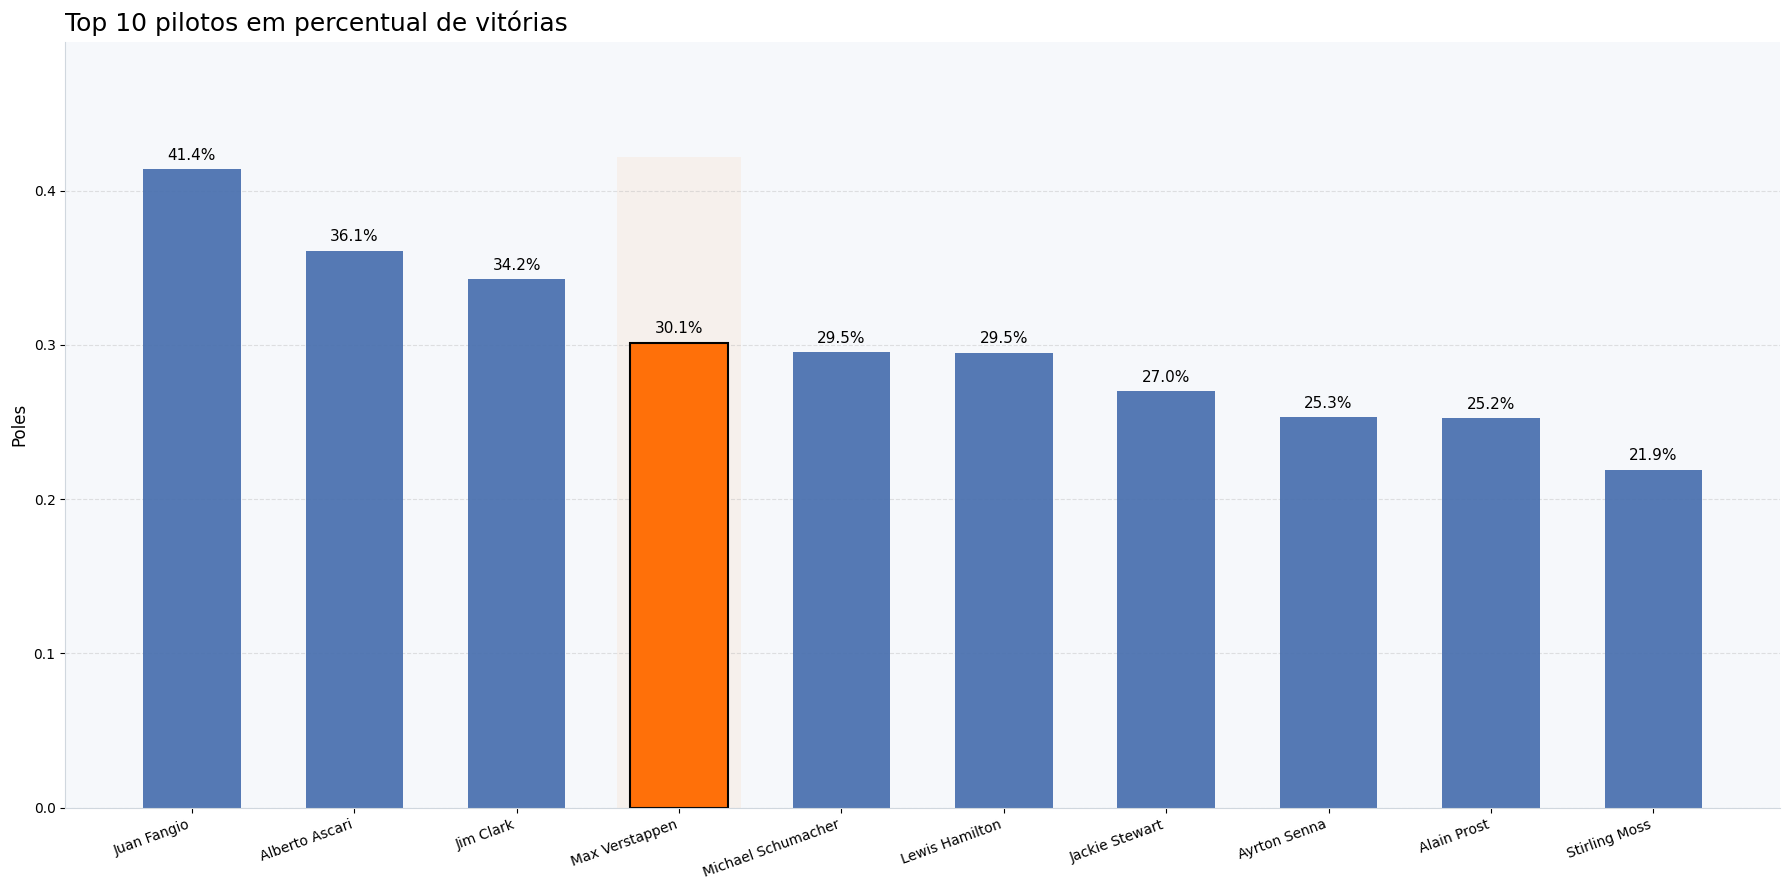

In [24]:
df_top_10_win_percentages['nome_e_idade'] = df_top_10_win_percentages.apply(lambda row: f"{row['driver_full_name']} ({round(row['oldest_race_win_age'], 2)} anos)", axis=1)

fxns.graf_top10_pilotos(
    df_top_10_win_percentages,
    col_nome="driver_full_name",
    col_valor="win_percentage",
    titulo="Top 10 pilotos em percentual de vitórias",
    xlabel="Poles",
    nome_a_destacar="Verstappen",
    orientation='vertical',
    mostrar_chips=False,
    valor_format_str="{:.1%}"
)

Ao final da temporada de 2024, Verstappen era o 4o piloto com maior percentual de vitórias da F1, considerando os pilotos que tiveram participação em mais de 5 corridas. Mas valem algumas observaçõe que não são tão óbvias ao observar o gráfico:

- O Verstappen tem muito mais corridas do que qualquer piloto que tem um percentual maior do que o dele;
- O Verstappen está com o maior percentual ao se considerar os pilotos da era "moderna".

# Mas e aí?

Todos esses números apresentados até agora são lindos e maravilhosos. Independente de qualquer contraponto, não há de se discutir que o Verstappen hoje em dia é um piloto mais do que consolidado e está entre os maiores nomes que a F1 já teve em sua história.

Porém... Tudo que trouxe até agora são só grandes números, estou comparando valores absolutos com outros pilotos sem isolar um grande fator: a equipe.

A F1, apesar de certas pessoas esquecerem às vezes, não é uma competição apenas entre pilotos, mas também uma competição de construtores (equipes), que acabam por influenciar muito o resultado individual de cada piloto, e aí a questão é a seguinte: como poderíamos tentar isolar esse fator em uma análise?

É muito difícil, mas acredito que com algumas premissas, consigo prosseguir a análise de forma a tentar fazer isso de duas formas: primeiro posso analisar a consistência de tempo de volta dos pilotos (um piloto bom tem que ser um piloto que consegue entregar resultado nos momentos mais importantes e que tem tempos de volta consistentes), e, além disso, podemos comparar os pilotos diretamente com os companheiros de equipe que tiveram, sendo que ambos possuem o mesmo equipamento (premissa importante).

Então agora, pretendo prosseguir a análise sem aprofundar em grandes números absolutos, mas indo um passo adiante na análise, entrando mais em detalhe nos números...

## Análise de Consistência:

A ideia aqui vai ser tentar fazer uma análise da consistência do piloto ao longo das corridas que participou. E eu não quero fazer isso em torno de uma análise de resultados, mas sim de tempos de volta, porque resultados, novamente, podem ser muito influenciados por externalidades (questões mecânicas, performance da equipe etc), mas, em tese, quem tem mais influência na consistência do tempo de volta, seja ele bom ou ruim, é o piloto. Então vamos lá:

In [25]:
df_lap_times

,race_name,year,race_date,circuit_name,circuit_country,driver_code,driver_forename,driver_surname,driver_full_name,driver_nationality,lap_number,position_on_lap,lap_time,lap_time_ms
0,Australian Grand Prix,1996,1996-03-10,Albert Park Grand Prix Circuit,Australia,VIL,Jacques,Villeneuve,Jacques Villeneuve,Canadian,1,1,1:43.702,103702
1,Australian Grand Prix,1996,1996-03-10,Albert Park Grand Prix Circuit,Australia,\N,Damon,Hill,Damon Hill,British,1,2,1:44.243,104243
2,Australian Grand Prix,1996,1996-03-10,Albert Park Grand Prix Circuit,Australia,\N,Eddie,Irvine,Eddie Irvine,British,1,3,1:44.981,104981
3,Australian Grand Prix,1996,1996-03-10,Albert Park Grand Prix Circuit,Australia,MSC,Michael,Schumacher,Michael Schumacher,German,1,4,1:45.188,105188
4,Australian Grand Prix,1996,1996-03-10,Albert Park Grand Prix Circuit,Australia,\N,Jean,Alesi,Jean Alesi,French,1,5,1:46.506,106506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589076,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,VER,Max,Verstappen,Max Verstappen,Dutch,58,6,1:28.780,88780
589077,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,GAS,Pierre,Gasly,Pierre Gasly,French,58,7,1:30.865,90865
589078,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,HUL,Nico,Hülkenberg,Nico Hülkenberg,German,58,8,1:30.040,90040
589079,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,ALO,Fernando,Alonso,Fernando Alonso,Spanish,58,9,1:28.621,88621
